## Neural network quantum process tomography

In this notebook, we demonstrate how neural networks can be used to represent
a quantum process and tackle the quantum process tomography task using
gradient-descent optimization (backpropagation). We consider random
discrete-variable quantum processes, construct a neural network that outputs
a set of Kraus operators and train the network to obtain an estimate of
the process.

In benchmarks against directly learning the Kraus operators (GD-QPT), the
neural-network QPT (NN-QPT) approach does not seem to show any significant
advantage. Nevertheless, this is an interesting direction to explore and
establishes a strong baseline for neural-network and other machine-learning
approaches to solve quantum characterization problems.

Also see our previous work on using neural networks for QST 
(https://github.com/quantshah/qst-cgan).

## Reference

[1] Shahnawaz Ahmed, Fernando Quijandría, Anton Frisk Kockum, "Gradient-descent
quantum process tomography by learning Kraus operators," (2022), [arXiv:2208.00812](https://arxiv.org/abs/2208.00812).

In [26]:
import sys
import os

from functools import partial


import numpy as np


import scipy as sp
from scipy import stats


from qutip import Qobj, fidelity, ket2dm, qeye, sigmax, sigmay, sigmaz
from qutip.superop_reps import kraus_to_choi
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from qutip.visualization import hinton


from tqdm.auto import tqdm
from tqdm import trange


import jax
from jax import numpy as jnp
from jax import jit, vmap, grad
from jax.config import config


import haiku as hk


import optax


from matplotlib import pyplot as plt
import matplotlib.colors as colors

from gd_qpt.core import (tensor_product_list, convert_to_jax, prod_pauli_vecs,
                         probas_pauli)
from gd_qpt.gd import predict, get_block, get_unblock, stiefel_update, GradientDescent


config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate a set of random Kraus operators from random unitaries

In [27]:
# number of qubits
n = 3

# Rank of process and number of Kraus operators
rank = 5
num_kraus = 7

# Hilbert space dimension
N = 2**n


def random_kraus(N, weights, rank, density=0.5):
    """Generates a sum of random unitaries to form a process given a set of
    weights and the rank of the process.

    Args:
        N (int): Hilbert space dimension.
        weights (array): Random weights that will be normalized.
        rank (int): The rank of the process.
        density (float): A number between 0, 1 to specifying the density of the
                         random unitaries.

    Returns:
        kraus_ops (array): A (k x N x N) complex-valued array of Kraus operators.
    """
    weights_unnormalized = weights**np.arange(rank)
    weights = weights_unnormalized / (weights_unnormalized).sum()
    kraus_ops = np.array([np.sqrt(w)*rand_unitary(N, density=density) for w in weights])
    return kraus_ops

### Convert to the Choi matrix and visualize the Choi matrix

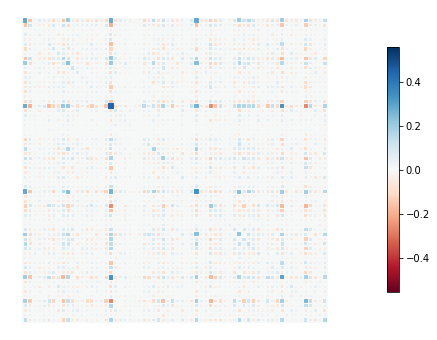

In [28]:
def choi(kraus_ops):
    """Takes the Kraus reprensentation of a channel and returns the Choi matrix.

    Args:
        kraus_ops (np.ndarray): The (k, N, N)-array representing k Kraus ops.

    Returns:
        np.array: A (N^2, N^2) array representing the Choi matrix.
    """
    r, N, N = kraus_ops.shape
    vectorized_kraus = kraus_ops.reshape(r, N ** 2)
    return np.einsum("ij, il -> jl", vectorized_kraus, vectorized_kraus.conj())



kraus_true = random_kraus(N, np.random.uniform(0.5, 1.), rank)
choi_qutip_test = kraus_to_choi([Qobj(kop) for kop in kraus_true])
choi_true = choi(kraus_true)
choi_qutip = Qobj(choi_true, dims=choi_qutip_test.dims, superrep="choi")


hinton(choi_true)
plt.show()

### Generate simulated probabilities of measurements with added Gaussian noise

We use the predict function that takes in a
set of Kraus operators, probes and measurements to generate probabilities and
test it against the `probas_pauli` function from the PLS paper:
https://github.com/Hannoskaj/Hyperplane_Intersection_Projection

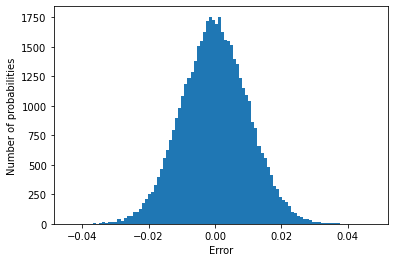

In [29]:
order = 100 # The Gaussian nosie has a std 1/order

Pk = prod_pauli_vecs(n)
probas = probas_pauli(n, kraus_true)

np.testing.assert_array_almost_equal(probas, predict(kraus_true, Pk, Pk))

# Add noise to the data
data = probas + np.random.normal(0, 1/order, size=probas.shape)
plt.hist(data.ravel() - probas.ravel(), bins=100)
plt.xlabel("Error")
plt.ylabel("Number of probabilities")
plt.show()


### Neural network that goes from batches of data -> Kraus operators

We construct a neural network that takes in a batch of data and generates a set
of Kraus operators that form an estimate for the process. The structure resembles
an autoencoder's encoder which generates a latent vector (the process) that
encodes the data. A decoder generates the same data from the encoded latent
vector. In our case, we know the decoding mechanism as it is simply a quantum
process acting on input probes and then measured. 

In [30]:
class Encoder(hk.Module):
    """Encoder model that goes from data -> Kraus operators."""
    def __init__(self, N, num_kraus=1):
        """Initialization.

        Args:
            N (int): Hilbert space dimension.
            num_kraus (int, optional): Number of Kraus operators. Defaults to 1.
        """
        super().__init__()
        self.N = N
        self.num_kraus = num_kraus

    def __call__(self, x):
        """The model forward function that takes in some data, flattens it,
        passes it through the model and generates a set of Kraus operators.

        Args:
            x (array): An array of expectation values.

        Returns:
            K (array[complex]): A complex-valued array (kN, N) of a 
                                    block of Kraus ops for a batch of the 
                                    input data x.
        """
        x = hk.Flatten()(x)
        x = x.reshape(1, -1)

        x = hk.Linear(128)(x)
        x = jax.nn.tanh(x)

        x = hk.Linear(128)(x)
        x = jax.nn.tanh(x)

        x = hk.Linear(self.N**2*self.num_kraus*2)(x)
        x = x.reshape(self.num_kraus, self.N, self.N, 2)
        
        k_ops = x.reshape(self.num_kraus, self.N, self.N, 2)
        K = get_block(k_ops[..., 0] + 1j*k_ops[..., 1])
        return K

### Initializing the model with a batch of the data and plotting Kraus operators obtained from it

Note that this set of Kraus operators will not be TP as there is no restriction
on the Kraus operators. It is not clear how to initialize the neural network
weights that makes its output TP. 

/Users/shahnawaz/miniconda3/envs/gd-qpt/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/Users/shahnawaz/miniconda3/envs/gd-qpt/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


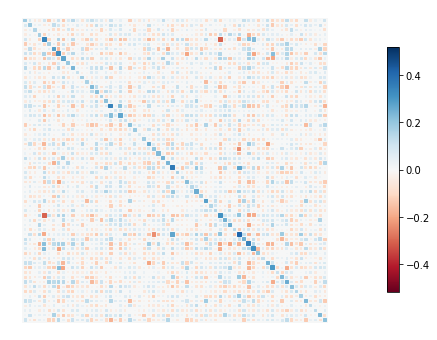

In [31]:
batch_size = 32
x = data[:batch_size, :batch_size]
rng_seq = hk.PRNGSequence(32)

model_forward = hk.transform(lambda x: Encoder(N, num_kraus=num_kraus)(x))
model_forward = hk.without_apply_rng(model_forward)
params = model_forward.init(next(rng_seq), x)

kraus_block_init = model_forward.apply(params, x)
kraus_init = get_unblock(kraus_block_init, num_kraus)

choi_initial_qutip = kraus_to_choi([Qobj(np.array(kop)) for kop in kraus_init])
choi_initial = choi_initial_qutip.full()

hinton(choi_initial)
plt.show()

### Loss function and gradients

The loss function takes in the model parameters, data, probes and measurements
to generate the estimate of the data from the process. It then computes a least
square error along with a regularization to give the loss. We can backpropagate
through the loss function to optimize the model parameters using batches of the
data, probes and measurements.

In [32]:
dag_vectorized = jax.vmap(lambda arr: jnp.conj(arr.T))


@partial(jit, static_argnums=4)
def loss(params, data=None, probes=None, measurements=None, num_kraus=None):
    """Loss function for the training assuming a predict function that can 
    generate probabilities for a measurement from the given process representation
    captured in params.

    Args:
        params (array): Parameters to optimize, e.g., Kraus operators.
        data (array): Data representing measured probabilities.
        probes (array): The probe operators.
        measurements (array): The measurement operators as Pauli vectors.
        num_kraus (int): The number of Kraus operators.

    Returns:
        loss (float): A scalar loss
    """
    kraus_block = model_forward.apply(params, data)

    k_ops = get_unblock(kraus_block, num_kraus)
    data_pred = predict(k_ops, probes, measurements)

    l2 = jnp.sum(((data - data_pred)**2))
    opsum = jnp.einsum('mij, mjk -> ik', dag_vectorized(k_ops), k_ops)

    I = jnp.eye(opsum.shape[0])
    trace_cost = jnp.linalg.norm(opsum - I, 1)
    
    return l2 + 0.001*jnp.linalg.norm(kraus_block, 1) + 0.001*trace_cost


print(loss(params, data[:batch_size, :batch_size], Pk[:batch_size],
           Pk[:batch_size], num_kraus))

22.36370745429702


### Loss gradients using batches of probes and measurements

In [33]:
def generate_batch(batch_size, len_indices):
    """Generates random indices to select a batch of the data 
        (probes x measurements) assuming same number of probes and measurements

    Args:
        batch_size (int): Batch size
        len_indices (int): Length of training data 
                          (probes and measurements are assumed to be the same)

    Returns:
        idx : A meshgrid of indices for selecting the data.
        idx1, idx2 (array): Indices for the probes and measurements.
    """
    idx1, idx2 = np.random.randint(0, len_indices, size=[2, batch_size])
    idx = tuple(np.meshgrid(idx1, idx2))
    return idx, idx1, idx2

idx, idx1, idx2 = generate_batch(batch_size, len(Pk))
grad_fn = jax.grad(loss)
grads = grad_fn(params, data.T[idx].real, Pk[idx1], Pk[idx2], num_kraus)

### Run gradient descent using batches of data

In [34]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
loss_hist = []


@jax.jit
def update(params, opt_state,
           data, probes, measurements):
    """Single SGD update step."""
    grads = jax.grad(loss)(params, data, probes, measurements, num_kraus)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

loss_hist = []

In [35]:
pbar = tqdm(range(15000))

for step in pbar:
    idx, idx1, idx2 = generate_batch(batch_size, data.shape[0])
    params, opt_state = update(params, opt_state, data.T[idx].real, Pk[idx1], Pk[idx2])
    idx, idx1, idx2 = generate_batch(batch_size, data.shape[0])
    lval = loss(params, data.T[idx], Pk[idx1], Pk[idx2], num_kraus)
    loss_hist.append(lval)
    pbar.set_description(desc='Loss: {}'.format(lval))

  0%|          | 0/15000 [00:00<?, ?it/s]

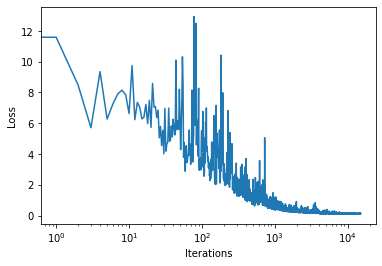

In [36]:
plt.semilogx(loss_hist)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

### Reconstructing the Kraus operators

The neural network takes as an input batches of data, but which batch of the
data should we use for the final reconstruction? Each batch will reconstruct
a slighlty different set of Kraus operators but it turns out that no matter
which batch of data we choose, the network always reconstructs almost the same
set of Kraus operators. We show this first with a single reconstruction and
then plotting the spread of fidelities from reconstructions using random batches
of the data.

In [37]:
idx, idx1, idx2 = generate_batch(batch_size, data.shape[0])
kraus_block = model_forward.apply(params, data.T[idx])
k_ops = get_unblock(kraus_block, num_kraus)

choi_nn = choi(k_ops)
choi_nn_qutip = Qobj(choi_nn, dims=choi_qutip.dims, superrep="choi")
nn_fidelity =  fidelity(choi_nn_qutip/2**n, choi_qutip/2**n)

/Users/shahnawaz/miniconda3/envs/gd-qpt/lib/python3.10/site-packages/qutip/qobj.py:530: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


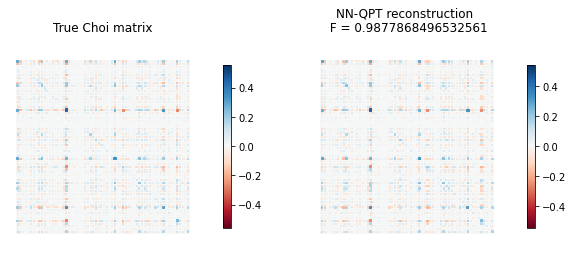

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
hinton(choi_true, ax=ax[0])
hinton(choi_nn, ax=ax[1])

ax[0].set_title("True Choi matrix")
ax[1].set_title(f"NN-QPT reconstruction \n F = {nn_fidelity}")

plt.show()

### Completely positive trace preserving?

The Kraus form keeps the reconstructed process completely positive (CP) but is
it trace preserving (TP)? We add a penalty for violations of the
trace-preserving property but since the optimizaton does not strictly guarantee
it, we cannot be sure that the process is TP.

Let us also plot the value of $\sum_l K_l^{\dagger}K_l$ to see how far from $I$
we are. This would give us an idea about the TP violation.

Is CP True
Is TP False


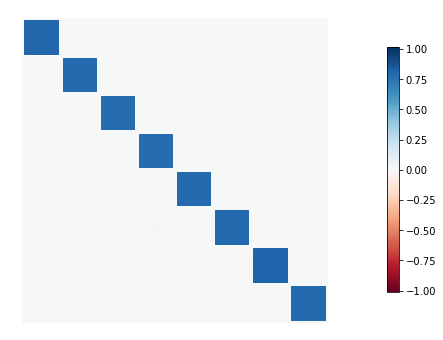

TP violation 0.1281737119322674


In [39]:
print(f"Is CP {choi_nn_qutip.iscp}")
print(f"Is TP {choi_nn_qutip.istp}")

# How much are we violating the TP condition?
opsum = jnp.einsum('mij, mjk -> ik', dag_vectorized(k_ops), k_ops) # Identity
I = jnp.eye(opsum.shape[0])

hinton(opsum)
plt.show()

print("TP violation", jnp.linalg.norm(I - opsum, 1))

### Which batch of data should we use for the reconstruction?

We can reconstruct the Kraus operators from different batches of the data and
plot the distribution of the fidelities for each reconstructed Kraus operator
to see the spread.

In [40]:
fidelitity_list = []

In [41]:
for i in tqdm(range(500)):
    idx, idx1, idx2 = generate_batch(batch_size, data.shape[0])
    kraus_block = model_forward.apply(params, data.T[idx])
    k_ops = get_unblock(kraus_block, num_kraus)

    choi_nn = choi(k_ops)
    choi_nn_qutip = Qobj(choi_nn, dims=choi_qutip.dims, superrep="choi")
    nn_fidelity =  fidelity(choi_nn_qutip/2**n, choi_qutip/2**n)

    fidelitity_list.append(nn_fidelity)

  0%|          | 0/500 [00:00<?, ?it/s]

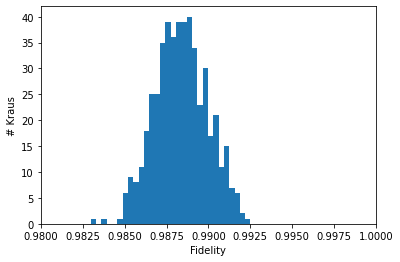

In [42]:
plt.hist(fidelitity_list, bins=30)
plt.xlabel("Fidelity")
plt.ylabel("# Kraus")
plt.xlim(0.98, 1.)
plt.show()

### Benchmark with GD-QPT

Let us benchmark the results with directly optimizing Kraus operators using
gradient descent on the Stiefel manifold.

In [61]:
GD = GradientDescent(N, num_kraus)
choi_gd = GD.fit(data, Pk, Pk, batch_size=32)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/shahnawaz/miniconda3/envs/gd-qpt/lib/python3.10/site-packages/qutip/qobj.py:530: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


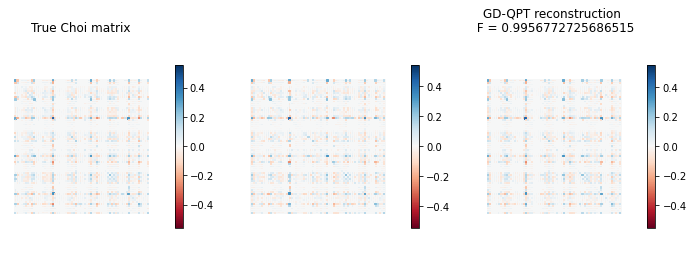

In [63]:
choi_gd_qutip = Qobj(choi_gd, dims=choi_qutip.dims, superrep="choi")
gd_fidelity =  fidelity(choi_gd_qutip/2**n, choi_qutip/2**n)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

hinton(choi_true, ax=ax[0])
hinton(choi_nn, ax=ax[1])
hinton(choi_gd, ax=ax[2])

ax[0].set_title("True Choi matrix")
ax[1].set_title(f"NN-QPT reconstruction \n F = {nn_fidelity}")
ax[2].set_title(f"GD-QPT reconstruction \n F = {gd_fidelity}")

plt.show()